## Stochastic linear program (SLP) to take into account uncertainty

In this sample we illustrate the usage of SLP for energy portfolios. Our demonstration implements a two-stage problem for a simple portfolio. It may be extended to any portfolio.

## Some prerequisites
### Basics

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from copy import deepcopy
import eaopack as eao
import matplotlib.pyplot as plt
np.random.seed(123)

### Parameter setting
Defining timegrid and main portfolio settings as well as settings for SLP. Note that we do not explain the setup in detail. Please refer to the basic samples to understand the concepts and parameters

For the SLP part we define the number of samples to be used. Using the parameter 'sigma' we can adjust uncertainty in price samples. The parameter 'start_future' defines the transition between the two stages of the SLP - present and future. In the two-stage setup we determine the optimal steps in the present given an uncertain future

In [2]:
Start = dt.date(2021,1,1)
End   = dt.date(2021,1,5)
start_future = Start+dt.timedelta(days=2)
n_samples    = 200
sigma        = .5

## Set up portfolio
(1) defining the assets of the portfolio (here a battery and a market with uncertain prices)
(2) definition of how prices are sampled

In [3]:
node = eao.assets.Node('home')
timegrid = eao.assets.Timegrid(Start, End, freq = 'h')
battery  = eao.assets.Storage(name='battery', nodes=node, cap_in= 1, cap_out=1, start_level= 24, end_level=24, size= 96)
market   = eao.assets.SimpleContract(name = 'market', nodes = node, min_cap= -10, max_cap= 10, price = 'spot')

def get_price(start, end, name = 'spot', n_samples = 1, sigma = 0.2, start_future = None, last_sample = None):
    dates = pd.date_range(start, end, freq ='h')
    prices = []
    n = len(dates)
    if not start_future is None:
        Ip = (dates <= pd.Timestamp(start_future))
    else:
        Ip = (dates <= dates.max())
    means     = 2+.5*np.sin(4.+np.linspace(0.,10., n)) 
    if last_sample is not None:
        means[Ip] = last_sample[Ip]
    for iS in range(0,n_samples):
        process = np.zeros(n)
        for i,pres in enumerate(Ip):
            if not pres:
                process[i] = process[i-1] + np.random.randn(1)*sigma    
        prices.append({'start' : dates.values, 'values': means + process})
    return prices

In [4]:
# define mean price
mean_price      = get_price(Start, End, sigma = 0.0)[0]
# standard format needs to be cast onto timegrid
mean_price_grid = {'spot' :timegrid.values_to_grid(mean_price)}

# create price samples for future (past included, but irrelevant)
# Note: May want to implement possibility to give only future prices
sample_prices = get_price(Start, End, n_samples=n_samples, sigma = sigma, start_future = start_future)
sample_prices_grid = []
for mys in sample_prices:
    sample_prices_grid.append( {'spot' :timegrid.values_to_grid(mys)} )


portf  = eao.portfolio.Portfolio([battery, market])

C:\Users\Anwender\AppData\Local\Temp\ipykernel_21864\2383451886.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  process[i] = process[i-1] + np.random.randn(1)*sigma


## Perform the optimization
For comparison we perform a deterministic optimization on the 'mean price' and an SLP on given samples for the future

In [5]:
op     = portf.setup_optim_problem(mean_price_grid, timegrid)
res_hard = op.optimize()
op_slp = eao.stoch_lin_prog.make_slp(portf = portf, 
                                    optim_problem= deepcopy(op),
                                    timegrid=timegrid,
                                    start_future = start_future, 
                                    samples = sample_prices_grid)
res_slp = op_slp.optimize()

## Create charts and interpret the results

C:\Users\Anwender\AppData\Local\Temp\ipykernel_21864\1060397432.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  collect['sample '+'{:1.0f}'.format(i)] = ts['spot']
C:\Users\Anwender\AppData\Local\Temp\ipykernel_21864\1060397432.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  collect['sample '+'{:1.0f}'.format(i)] = ts['spot']
C:\Users\Anwender\AppData\Local\Temp\ipykernel_21864\1060397432.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h

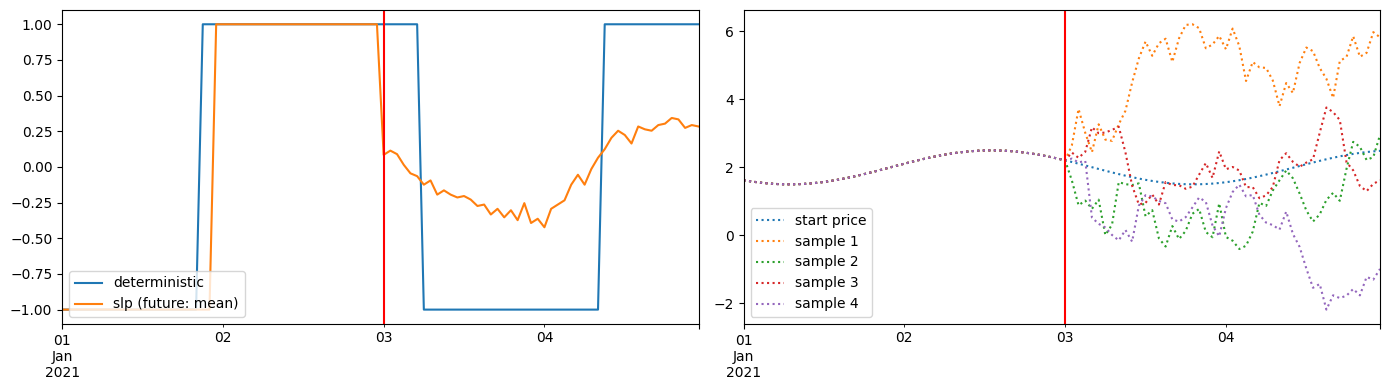

In [6]:
### check and illustrate results
out_hard = eao.io.extract_output(portf, op,     res_hard)
out_slp  = eao.io.extract_output(portf, op_slp, res_slp)

collect = pd.DataFrame()
collect['deterministic'] = out_hard['dispatch']['battery']
collect['slp (future: mean)']  = out_slp['dispatch']['battery']
collect['start price'] = mean_price_grid['spot']
timegrid.set_restricted_grid(end = start_future)
for i, ts in enumerate(sample_prices_grid):
    ts['spot'][timegrid.restricted.I] = mean_price_grid['spot'][timegrid.restricted.I]
    collect['sample '+'{:1.0f}'.format(i)] = ts['spot']    

fig, ax = plt.subplots(1,2, tight_layout = True, figsize=(14,4))
collect[['deterministic','slp (future: mean)']].plot(ax = ax[0])
collect[['start price', 'sample 1', 'sample 2', 'sample 3', 'sample 4']].plot(ax = ax[1], style = ':')
ax[0].axvline(x = start_future, c = 'r')
ax[1].axvline(x = start_future, c = 'r')
ax[0].legend(loc = 'lower left')
ax[1].legend(loc = 'lower left')
plt.show()

### Interpretation

The red line indicates the start of the uncertain future (Jan 3). While for the pending decision (stage 1) prices are certain, for the future (stage 2) we have five price samples that encode the uncertainty. Solutions in this example are relatively similar -- but note that the deterministic optimization charges the storage maximally until Jan 03 as future prices are higher than present prices. Since uncertainty is high, the SLP solution starts discharching earlier, as future prices may be higher today but are uncertain. 

### Two-stage vs. multi-stage problem: 

In our implementation we provide a formulation of a two-stage SLP generically for any  portfolio structure. For the two-stage case problems can typically be handled and often already provide a good appoximation. For the multi-stage case we believe that it will be necessary to resort to numerical approximations, strategies that are specific to the given portfolio or others such as methods from machine learning. Providing a solution to the SLP for a relevant problem class could be a valuable research thread for further work.

## Backtesting: SLP vs. hard optimization

We're backtesting the decisions of the hard and SLP decision by sampling over future price outcomes. Naturally, this backtest is more of an illustration for this specific example.

In [7]:
n_test = 1000 # number of samples for backtesting
# decisions to fix (hard and SLP)
fix_slp  = {'I': start_future, 'x': res_slp.x}
fix_hard = {'I': start_future, 'x': res_hard.x}
# draw random prices and perform optimization for future
sample_prices = get_price(Start, End, n_samples=n_test, sigma = sigma, start_future = start_future)
values_slp  = []
values_hard = []
for mys in sample_prices:
    my_price = {'spot' :timegrid.values_to_grid(mys)} 
    op_test_hard = portf.setup_optim_problem(my_price, timegrid, fix_time_window=fix_hard)
    op_test_slp = portf.setup_optim_problem(my_price, timegrid, fix_time_window=fix_slp)    
    res_test_hard = op_test_hard.optimize()
    res_test_slp  = op_test_slp.optimize()    
    values_slp.append(res_test_slp.value)
    values_hard.append(res_test_hard.value)

C:\Users\Anwender\AppData\Local\Temp\ipykernel_21864\2383451886.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  process[i] = process[i-1] + np.random.randn(1)*sigma


In [8]:
print('Mean portfolio value hard optimization: '+'{:2.2f}'.format(np.asarray(values_hard).mean()))
print('Mean portfolio value SLP optimization: '+'{:2.2f}'.format(np.asarray(values_slp).mean()))

print('Variance portfolio value hard optimization: '+'{:2.2f}'.format(np.asarray(values_hard).var()))
print('Variance portfolio value SLP optimization: '+'{:2.2f}'.format(np.asarray(values_slp).var()))

Mean portfolio value hard optimization: 67.53
Mean portfolio value SLP optimization: 68.01
Variance portfolio value hard optimization: 605.14
Variance portfolio value SLP optimization: 497.74


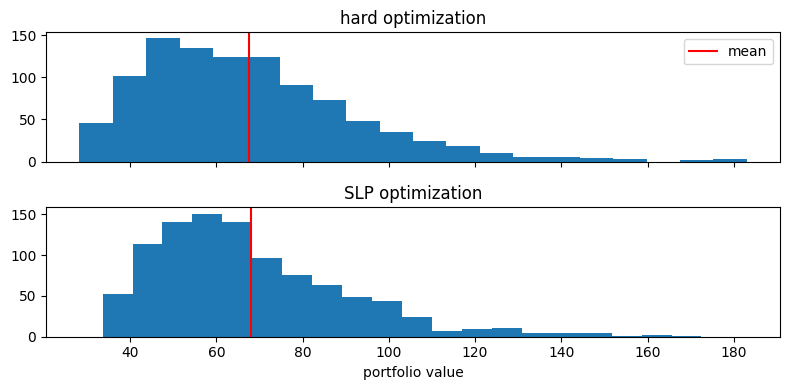

In [9]:
fig, ax = plt.subplots(2,1, tight_layout = True, figsize=(8,4), sharex = 'col')
ax[0].hist(np.asarray(values_hard), bins = 20)
ax[1].hist(np.asarray(values_slp), bins = 20)
ax[0].set_title('hard optimization')
ax[1].set_xlabel('portfolio value')
ax[1].set_title('SLP optimization')
ax[0].axvline(x = np.asarray(values_hard).mean(), c = 'r', label = 'mean')
ax[1].axvline(x = np.asarray(values_slp).mean(), c = 'r')
ax[0].legend()
plt.show()

The comparison shows only relatively small differences in the value. However, this was to be expected, since hard and SLP decisions only differed in a small timeframe for the immediate future. Variances differ more significantly, as also the histograms show.